In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd
import cv2
from keras.utils.np_utils import to_categorical

In [4]:
with open('german-traffic-signs/train.p','rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/train.p','rb') as f:
  test_data = pickle.load(f)
with open('german-traffic-signs/train.p','rb') as f:
  valid_data = pickle.load(f)

x_train , y_train = train_data['features'] ,train_data['labels']
x_test , y_test = train_data['features'] ,train_data['labels']
x_valid , y_valid = train_data['features'] ,train_data['labels']

In [5]:
print(x_train.shape)
print(y_train.shape)

(34799, 32, 32, 3)
(34799,)


In [6]:
assert(x_train.shape[0]==y_train.shape[0]),'train images not equal to train labels'
assert(x_test.shape[0]==y_test.shape[0]),'train images not equal to train labels'
assert(x_valid.shape[0]==y_valid.shape[0]),'train images not equal to train labels'

assert(x_train.shape[1:]==(32,32,3)),'image dimension must be 32 X 32 X 3'
assert(x_test.shape[1:]==(32,32,3)),'image dimension must be 32 X 32 X 3'
assert(x_valid.shape[1:]==(32,32,3)),'image dimension must be 32 X 32 X 3'

In [7]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
data.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [8]:
data['ClassId'].unique().shape

(43,)

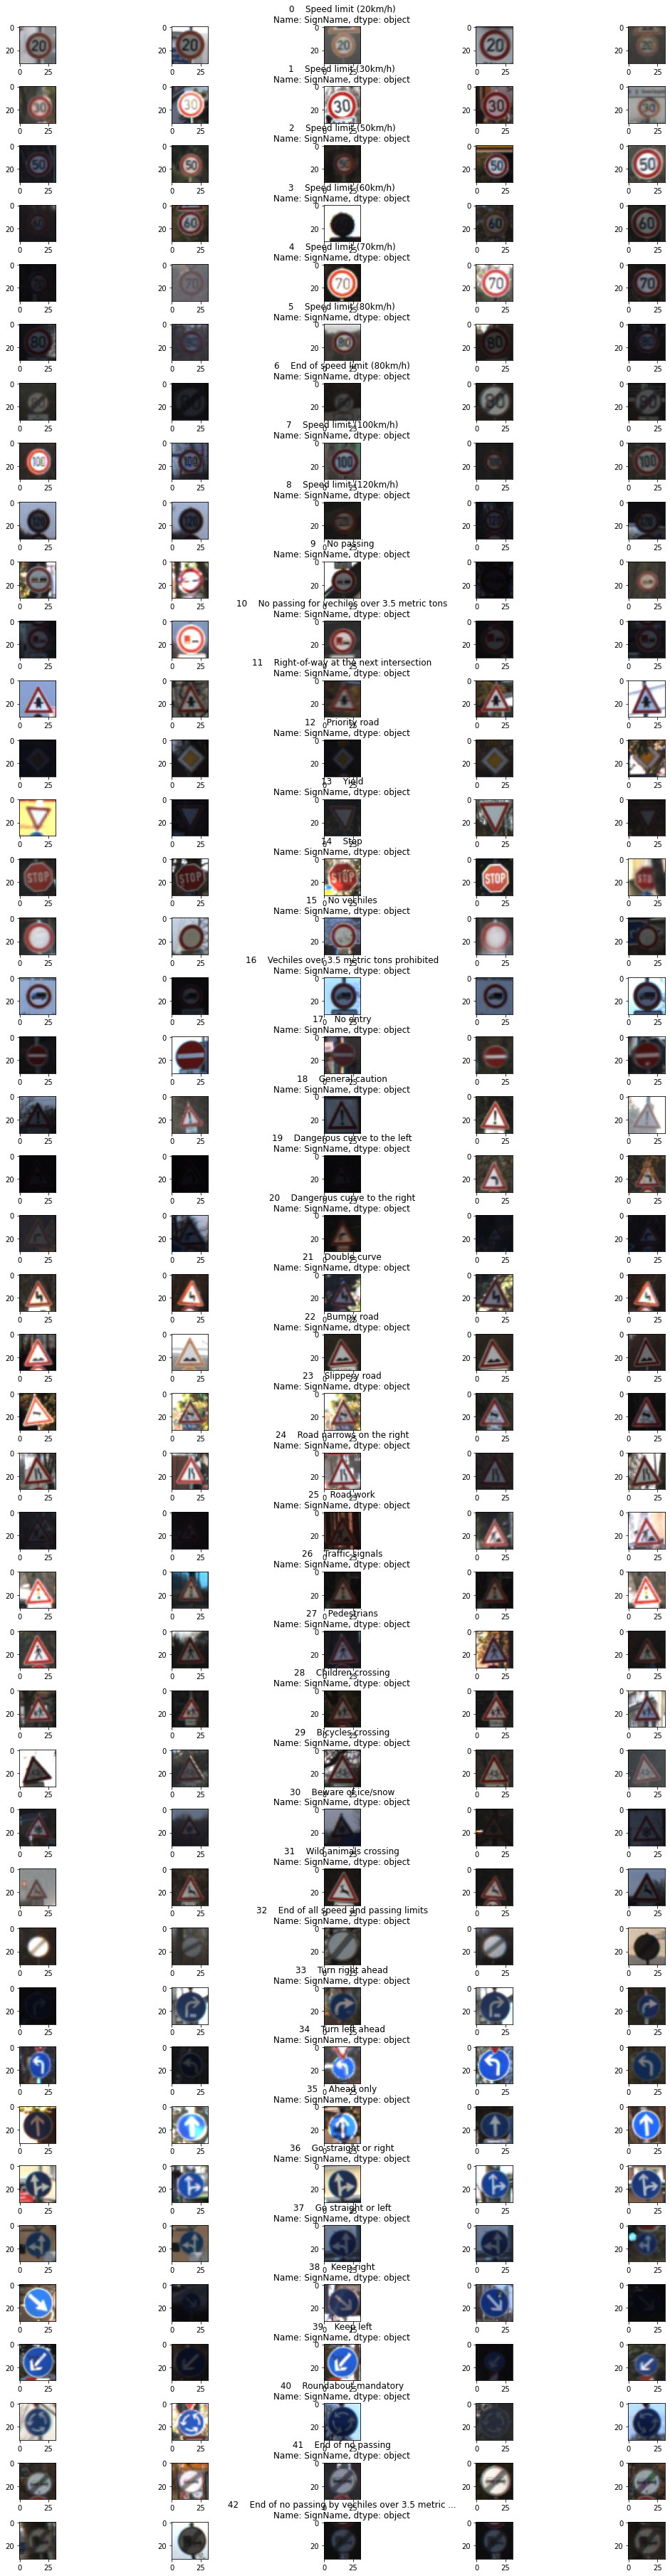

In [9]:
#x_train.shape[1:]
n_cols= 5
n_classes=43

fig,axes = plt.subplots(nrows=n_classes,ncols=n_cols,figsize=(15,50))
fig.tight_layout()

for i in range(n_cols):
  for j in range(n_classes):
    selected_images = x_train[y_train==j]
    image = selected_images[random.randint(0,(len(selected_images)-1)),:,:,:]
    axes[j][i].imshow(image)
    axes[j][i].axis=('off')
    if i ==2:
      axes[j][i].set_title(str(data.SignName[data.ClassId==j]))     #j=data.Signname[data.Classes==j]

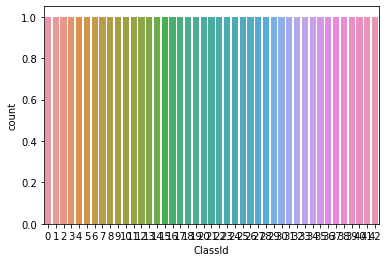

In [10]:
sns.countplot(data.ClassId)
plt.show()

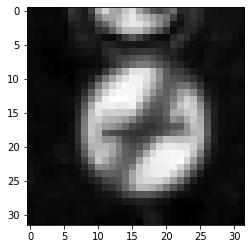

In [11]:
def grayscale(image):
  gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  return gray
plt.imshow(grayscale(x_train[0]),cmap='gray')
plt.show()

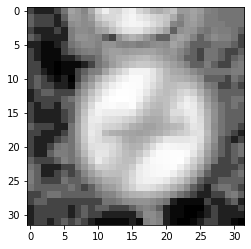

In [12]:
def equalize(image):
  image = cv2.equalizeHist(image)
  return image
img = grayscale(x_train[0])
img = equalize(img)
plt.imshow(img,cmap='gray')

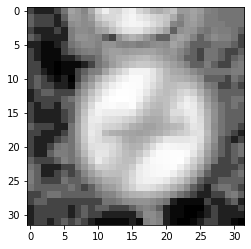

In [13]:
def preprocess(image):
  image = equalize(grayscale(image))
  image=image/255
  return image
plt.imshow(preprocess(x_train[0]),cmap='gray')
plt.show()

In [14]:
x_train = np.array(list(map(preprocess,x_train)))
x_test = np.array(list(map(preprocess,x_test)))
x_valid = np.array(list(map(preprocess,x_valid)))

In [15]:
x_train = x_train.reshape(x_train.shape[0],32,32,1)
x_test = x_test.reshape(x_test.shape[0],32,32,1)
x_valid = x_valid.reshape(x_valid.shape[0],32,32,1)

y_train = to_categorical(y_train,43)
y_test = to_categorical(y_test,43)
y_valid = to_categorical(y_valid,43)

In [16]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1,rotation_range=10,zoom_range=0.1,shear_range=0.1)

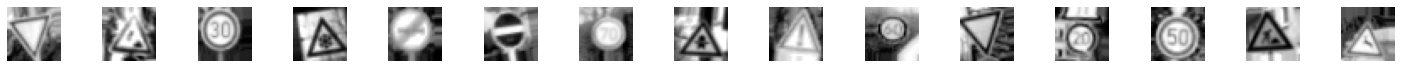

In [36]:
#calling the datagenerator to augment in real time
batches = datagen.flow(x_train,y_train,batch_size=20)
x_batch,y_batch = next(batches)

fig, axes = plt.subplots(1,15,figsize=(20,5))
fig.tight_layout()

for i in range(15):
  axes[i].imshow(x_batch[i].reshape(32,32),cmap='gray')
  axes[i].axis('off')


In [18]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers.convolutional import Conv2D,MaxPooling2D
from keras.optimizers import Adam 

In [19]:
def lenet_model():
  model=Sequential()
  model.add(Conv2D(60, (5,5),input_shape=(32,32,1),activation='relu'))
  model.add(Conv2D(60, (5,5),activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Flatten())
  model.add(Dense(500,activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(n_classes,activation='softmax'))
  model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
  return model


In [20]:
model = lenet_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 60)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8640)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               4320500   
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 43)               

In [21]:
h = model.fit_generator(datagen.flow(x_train,y_train,batch_size=50),steps_per_epoch = 2000,epochs = 10,validation_data = (x_valid,y_valid),shuffle=1,verbose=1)

Epoch 1/10
2000/2000 [==============================] - 635s 318ms/step - loss: 0.9532 - accuracy: 0.7127 - val_loss: 0.1123 - val_accuracy: 0.9694
Epoch 2/10
2000/2000 [==============================] - 667s 334ms/step - loss: 0.2904 - accuracy: 0.9075 - val_loss: 0.0238 - val_accuracy: 0.9940
Epoch 3/10
2000/2000 [==============================] - 645s 323ms/step - loss: 0.1955 - accuracy: 0.9378 - val_loss: 0.0205 - val_accuracy: 0.9949
Epoch 4/10
2000/2000 [==============================] - 593s 296ms/step - loss: 0.1508 - accuracy: 0.9524 - val_loss: 0.0145 - val_accuracy: 0.9962
Epoch 5/10
2000/2000 [==============================] - 1045s 523ms/step - loss: 0.1267 - accuracy: 0.9600 - val_loss: 0.0095 - val_accuracy: 0.9970
Epoch 6/10
2000/2000 [==============================] - 589s 294ms/step - loss: 0.1138 - accuracy: 0.9639 - val_loss: 0.0081 - val_accuracy: 0.9978
Epoch 7/10
 820/2000 [===========>..................] - ETA: 5:28 - loss: 0.1050 - accuracy: 0.9678

KeyboardInterrupt: 

In [ ]:
plt.plot(h.history['loss'],label='loss')
plt.plot(h.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(h.history['acc'],label='acc')
plt.plot(h.history['val_acc'],label='val_acc')
plt.legend()
plt.show()


In [ ]:
model.save("traffic_model.h5")

32

In [33]:
n_classes

43